<a href="https://colab.research.google.com/github/Sachini007/Data-Storm-3.0/blob/main/03-27/main_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.model_selection import train_test_split

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adadelta,Adam,RMSprop 
from tensorflow.keras.callbacks import EarlyStopping
import lightgbm as lgb
import itertools
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
import seaborn as sns

# load data

In [ ]:
#%cd /content/drive/MyDrive/Data-Storm-3.0/03-26

In [ ]:
file_name = 'train_data.csv'
train_df = pd.read_csv(file_name,parse_dates=['DateID'] )
print(train_df.shape)
train_df.head()

(19921, 4)


,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,2021-11-06,7
1,category_4,836584,2021-11-18,16
2,category_1,370195,2022-01-24,6
3,category_2,172582,2021-10-30,5
4,category_2,1006009,2021-10-30,5


In [ ]:
train_df = train_df.sort_values("DateID").reset_index(drop = True)

In [ ]:
train_df.index.name = 'ID'

In [ ]:
train_df.head()

,CategoryCode,ItemCode,DateID,DailySales
ID,,,,
0,category_2,174436,2021-10-01,9
1,category_2,118033,2021-10-01,4
2,category_2,20824,2021-10-01,7
3,category_1,1061341,2021-10-01,11
4,category_1,76399,2021-10-01,14


In [ ]:
train_df.dtypes

CategoryCode            object
ItemCode                 int64
DateID          datetime64[ns]
DailySales               int64
dtype: object

In [ ]:
validation_df = pd.read_csv('new_validation_data.csv',parse_dates=['DateID'])
# validation_df.drop('Week', axis=1, inplace=True)
print(validation_df.shape)
validation_df = validation_df.sort_values("DateID").reset_index(drop = True)
validation_df.head()

(2590, 4)


,CategoryCode,ItemCode,Week,DateID
0,category_2,1044502,w1,2022-02-14
1,category_2,172582,w1,2022-02-14
2,category_3,1066570,w1,2022-02-14
3,category_2,1090240,w1,2022-02-14
4,category_3,1097143,w1,2022-02-14


In [ ]:
validation_df.index.name = 'ID'

In [ ]:
validation_df_original = validation_df.copy()

In [ ]:
test_df = pd.read_csv('new_test_data.csv',parse_dates=['DateID'])
# test_df.drop('Week', axis=1, inplace=True)
print(test_df.shape)
test_df = test_df.sort_values("DateID").reset_index(drop = True)
test_df.head()

(2639, 4)


,CategoryCode,ItemCode,Week,DateID
0,category_1,370195,w1,2022-02-14
1,category_1,1032559,w1,2022-02-14
2,category_2,174436,w1,2022-02-14
3,category_2,262384,w1,2022-02-14
4,category_1,371104,w1,2022-02-14


In [ ]:
test_df.index.name = 'ID'

In [ ]:
test_df_original = test_df.copy()

# Daily Sales distribution

In [ ]:
train_df['DailySales_bins'] = pd.cut(train_df.DailySales,[0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,150,200,250,300,350,400,450])
print('Max sale:', train_df.DailySales.max())
print('Min sale:', train_df.DailySales.min())
print('Avg sale:', train_df.DailySales.mean())
print('Total sale:', train_df.DailySales.sum())

Max sale: 434
Min sale: 1
Avg sale: 7.351889965363185
Total sale: 146457


In [ ]:
pd.value_counts(train_df.DailySales_bins)

(0, 1]        4413
(1, 2]        3503
(2, 3]        2376
(3, 4]        1887
(10, 20]      1868
(4, 5]        1297
(5, 6]        1026
(6, 7]         770
(7, 8]         583
(20, 30]       551
(8, 9]         480
(9, 10]        428
(50, 100]      304
(30, 40]       202
(40, 50]       128
(100, 150]      83
(150, 200]      15
(200, 250]       4
(250, 300]       1
(300, 350]       1
(400, 450]       1
(350, 400]       0
Name: DailySales_bins, dtype: int64

<AxesSubplot:title={'center':'Sales distribution'}>

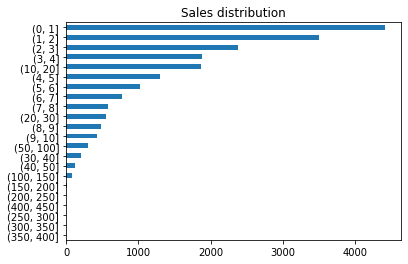

In [ ]:
sales_count = pd.value_counts(train_df.DailySales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', )

In [ ]:
total_points = pd.value_counts(train_df.DailySales_bins).sum()
pd.value_counts(train_df.DailySales_bins).apply(lambda s: (s/total_points)*100)

(0, 1]        22.152502
(1, 2]        17.584459
(2, 3]        11.927112
(3, 4]         9.472416
(10, 20]       9.377039
(4, 5]         6.510717
(5, 6]         5.150344
(6, 7]         3.865268
(7, 8]         2.926560
(20, 30]       2.765925
(8, 9]         2.409518
(9, 10]        2.148487
(50, 100]      1.526028
(30, 40]       1.014005
(40, 50]       0.642538
(100, 150]     0.416646
(150, 200]     0.075297
(200, 250]     0.020079
(250, 300]     0.005020
(300, 350]     0.005020
(400, 450]     0.005020
(350, 400]     0.000000
Name: DailySales_bins, dtype: float64

# Sales variation across category

In [ ]:
sales_pivoted_df = pd.pivot_table(train_df, index='CategoryCode', values=['DailySales','DateID'], columns='ItemCode', aggfunc=np.mean)
sales_pivoted_df

DailySales                                                    \
ItemCode        3418      3427      7666      9925      16936     17287     
CategoryCode                                                                
category_1     9.829457  6.538462       NaN       NaN       NaN  4.293478   
category_2          NaN       NaN       NaN  2.479167       NaN       NaN   
category_3          NaN       NaN  14.80531       NaN  8.135135       NaN   
category_4          NaN       NaN       NaN       NaN       NaN       NaN   

                                                         ...            \
ItemCode        17296      20824      23200     23569    ...   1098502   
CategoryCode                                             ...             
category_1    71.191176        NaN        NaN       NaN  ...       NaN   
category_2          NaN  18.647059        NaN  3.530973  ...  1.594937   
category_3          NaN        NaN        NaN       NaN  ...       NaN   
category_4          NaN        NaN  13.860759       NaN  ...       NaN   

                                                                        \
ItemCode       1101553   1101562 1101571   1101661   1101769   1103056   
CategoryCode                                                             
category_1         NaN       NaN     NaN       NaN       NaN       NaN   
category_2    1.906667  2.265957     4.8       NaN  2.921053  2.826923   
category_3         NaN       NaN     NaN  6.205607       NaN       NaN   
category_4         NaN       NaN     NaN       NaN       NaN       NaN   

                                            
ItemCode       1105009   1105018   1105027  
CategoryCode                                
category_1         NaN       NaN       NaN  
category_2    1.898551  1.863636  1.961538  
category_3         NaN       NaN       NaN  
category_4         NaN       NaN       NaN  

[4 rows x 194 columns]

In [ ]:
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['AvgDailySale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)
sales_across_store_df['AvgDailySale']

CategoryCode
category_1     6.280729
category_2     4.139096
category_3    10.856383
category_4    15.820818
Name: AvgDailySale, dtype: float64

In [ ]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.AvgDailySale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.AvgDailySale.values,
        color = sales_across_store_df.AvgDailySale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg Daily sales per Category',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Category',
        ticklen= 4,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Daily Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

# Sales variation across item

In [ ]:
sales_across_item_df = sales_pivoted_df.copy()
    # Aggregate the sales per item and add it as a new row in the same dataframe
sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
    # Note the 11th index row, which is the average sale of each of the item across all the stores
    #display(sales_across_item_df.loc[11:])
avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['ItemID', 'AvgDailySale'])
    # And finally, sort by avg sale
avg_sales_per_item_across_stores_df.sort_values(by='AvgDailySale', ascending=False, inplace=True)
    # Display the top 10 rows
avg_sales_per_item_across_stores_df.head(10)

,ItemID,AvgDailySale
60,61,89.355556
49,50,71.310606
6,7,71.191176
157,158,34.094118
48,49,22.742647
90,91,22.442478
54,55,22.213235
18,19,20.066667
7,8,18.647059
121,122,18.029851


In [ ]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.AvgDailySale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 200)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.ItemID.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 200,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

# time series visualization of sales

In [ ]:
# store_item_df = train_df.copy()
# # First, let us filterout the required data
# item_id = 117610   # Some item
# print('Before filter:', store_item_df.shape)
# store_item_df = store_item_df[store_item_df.ItemCode == item_id]
# print('After filter:', store_item_df.shape)
# store_item_df.head()

# store_item_ts_data = [go.Scatter(
#         x=store_item_df.DateID,
#         y=store_item_df.DailySales)]
# py.iplot(store_item_ts_data)
    

Feature Engineering

In [ ]:
# def date_features(df):
#     # Date Features
#     # df['date'] = pd.to_datetime(df['DateID'])
#     df['year'] = df.DateID.dt.year
#     df['month'] = df.DateID.dt.month
#     df['day'] = df.DateID.dt.day
#     df['dayofyear'] = df.DateID.dt.dayofyear
#     df['dayofweek'] = df.DateID.dt.dayofweek
#     df['weekofyear'] = df.DateID.dt.weekofyear
    
#     # Additionnal Data Features
#     df['day^year'] = np.log((np.log(df['dayofyear'] + 1)) ** (df['year'] - 2000))
    
#     # Drop date
#     df.drop('DateID', axis=1, inplace=True)
    
#     return df

In [ ]:
# train_df, validation_df, test_df = date_features(train_df), date_features(validation_df), date_features(test_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
train_df.head()

,CategoryCode,ItemCode,DateID,DailySales,DailySales_bins
ID,,,,,
0,category_2,174436,2021-10-01,9,"(8, 9]"
1,category_2,118033,2021-10-01,4,"(3, 4]"
2,category_2,20824,2021-10-01,7,"(6, 7]"
3,category_1,1061341,2021-10-01,11,"(10, 20]"
4,category_1,76399,2021-10-01,14,"(10, 20]"


In [ ]:
validation_df.head()

,CategoryCode,ItemCode,Week,DateID
ID,,,,
0,category_2,1044502,w1,2022-02-14
1,category_2,172582,w1,2022-02-14
2,category_3,1066570,w1,2022-02-14
3,category_2,1090240,w1,2022-02-14
4,category_3,1097143,w1,2022-02-14


In [ ]:
def create_date_features(df):
    df['month'] = df.DateID.dt.month
    df['day_of_month'] = df.DateID.dt.day
    df['day_of_year'] = df.DateID.dt.dayofyear
    df['week_of_year'] = df.DateID.dt.weekofyear
    df['day_of_week'] = df.DateID.dt.dayofweek + 1
    df['year'] = df.DateID.dt.year
    df["is_wknd"] = df.DateID.dt.weekday // 4
    # df["quarter"] = df.date.dt.quarter
    df['is_month_start'] = df.DateID.dt.is_month_start.astype(int)
    df['is_month_end'] = df.DateID.dt.is_month_end.astype(int)
    df['is_quarter_start'] = df.DateID.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.DateID.dt.is_quarter_end.astype(int)
    df['is_year_start'] = df.DateID.dt.is_year_start.astype(int)
    df['is_year_end'] = df.DateID.dt.is_year_end.astype(int)
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    return df

In [ ]:
train_df, validation_df, test_df = create_date_features(train_df), create_date_features(validation_df), create_date_features(test_df)

c:\Python37\cv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
train_df

,CategoryCode,ItemCode,DateID,DailySales,DailySales_bins,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
ID,,,,,,,,,,,,,,,,,,,
0,category_2,174436,2021-10-01,9,"(8, 9]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
1,category_2,118033,2021-10-01,4,"(3, 4]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
2,category_2,20824,2021-10-01,7,"(6, 7]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
3,category_1,1061341,2021-10-01,11,"(10, 20]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
4,category_1,76399,2021-10-01,14,"(10, 20]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19916,category_2,57058,2022-02-13,3,"(2, 3]",2,13,44,6,7,2022,1,0,0,0,0,0,0,0
19917,category_1,1084498,2022-02-13,4,"(3, 4]",2,13,44,6,7,2022,1,0,0,0,0,0,0,0
19918,category_2,1067092,2022-02-13,13,"(10, 20]",2,13,44,6,7,2022,1,0,0,0,0,0,0,0


In [ ]:
validation_df

,CategoryCode,ItemCode,Week,DateID,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
ID,,,,,,,,,,,,,,,,,,
0,category_2,1044502,w1,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
1,category_2,172582,w1,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
2,category_3,1066570,w1,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
3,category_2,1090240,w1,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
4,category_3,1097143,w1,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,category_2,1026871,w4,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1
2586,category_2,1071124,w4,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1
2587,category_1,1050046,w4,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1


In [ ]:
test_df

,CategoryCode,ItemCode,Week,DateID,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
ID,,,,,,,,,,,,,,,,,,
0,category_1,370195,w1,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
1,category_1,1032559,w1,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
2,category_2,174436,w1,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
3,category_2,262384,w1,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
4,category_1,371104,w1,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,category_1,371104,w4,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1
2635,category_1,42424,w4,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1
2636,category_3,1090024,w4,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1


In [ ]:
validation_df = validation_df.drop('Week', axis=1)
test_df = test_df.drop('Week', axis=1)

In [ ]:
train_df

,CategoryCode,ItemCode,DateID,DailySales,DailySales_bins,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
ID,,,,,,,,,,,,,,,,,,,
0,category_2,174436,2021-10-01,9,"(8, 9]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
1,category_2,118033,2021-10-01,4,"(3, 4]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
2,category_2,20824,2021-10-01,7,"(6, 7]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
3,category_1,1061341,2021-10-01,11,"(10, 20]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
4,category_1,76399,2021-10-01,14,"(10, 20]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19916,category_2,57058,2022-02-13,3,"(2, 3]",2,13,44,6,7,2022,1,0,0,0,0,0,0,0
19917,category_1,1084498,2022-02-13,4,"(3, 4]",2,13,44,6,7,2022,1,0,0,0,0,0,0,0
19918,category_2,1067092,2022-02-13,13,"(10, 20]",2,13,44,6,7,2022,1,0,0,0,0,0,0,0


In [ ]:
validation_df

,CategoryCode,ItemCode,DateID,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
ID,,,,,,,,,,,,,,,,,
0,category_2,1044502,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
1,category_2,172582,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
2,category_3,1066570,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
3,category_2,1090240,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
4,category_3,1097143,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,category_2,1026871,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1
2586,category_2,1071124,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1
2587,category_1,1050046,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1


In [ ]:
test_df

,CategoryCode,ItemCode,DateID,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
ID,,,,,,,,,,,,,,,,,
0,category_1,370195,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
1,category_1,1032559,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
2,category_2,174436,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
3,category_2,262384,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
4,category_1,371104,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,category_1,371104,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1
2635,category_1,42424,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1
2636,category_3,1090024,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1


In [ ]:
# train_df['daily_avg']  = train_df.groupby(['ItemCode','CategoryCode','day_of_week'])['DailySales'].transform('mean')
# train_df['monthly_avg'] = train_df.groupby(['ItemCode','CategoryCode','month'])['DailySales'].transform('mean')
# train_df = train_df.dropna()

# # Average sales for Day_of_week = d per Item,Store
# daymonth_avg = train_df.groupby(['ItemCode','CategoryCode','day_of_week'])['DailySales'].mean().reset_index()
# # Average sales for Month = m per Item,Store
# monthly_avg = train_df.groupby(['ItemCode','CategoryCode','month'])['DailySales'].mean().reset_index()

In [ ]:
#train_df.head()

In [ ]:
#Merge Test with Daily Avg, Monthly Avg
# def merge(df1, df2, col,col_name):
    
#     df1 = pd.merge(df1, df2, how='left', on=None, left_on=col, right_on=col,
#             left_index=False, right_index=False, sort=True,
#              copy=True, indicator=False)
    
#     df1 = df1.rename(columns={'DailySales':col_name})
#     return df1

In [ ]:
#daymonth_avg.head()

In [ ]:
#monthly_avg.head()

In [ ]:
# # Add Daily_avg and Monthly_avg features to test 
# validation_df = merge(validation_df, daymonth_avg, ['ItemCode','CategoryCode','day_of_week'],'daily_avg')
# validation_df = merge(validation_df, monthly_avg,['ItemCode','CategoryCode','month'],'monthly_avg')

# # Add Daily_avg and Monthly_avg features to test 
# test_df = merge(test_df, daymonth_avg, ['ItemCode','CategoryCode','day_of_week'],'daily_avg')
# test_df = merge(test_df, monthly_avg,['ItemCode','CategoryCode','month'],'monthly_avg')

# # Sales Rolling mean sequence per item 
# rolling_10 = train_df.groupby(['ItemCode'])['DailySales'].rolling(5).mean().reset_index()
# train_df['rolling_mean'] = rolling_10['DailySales'] 

# # 90 last days of training rolling mean sequence added to test data
# rolling_last90 = train_df.groupby(['ItemCode','CategoryCode'])['rolling_mean'].tail(10).copy()
# validation_df['rolling_mean'] = rolling_last90.reset_index().drop('ID', axis=1)
# test_df['rolling_mean'] = rolling_last90.reset_index().drop('ID', axis=1)

# # Shifting rolling mean 3 months
# train_df['rolling_mean'] = train_df.groupby(['ItemCode'])['rolling_mean'].shift(10) # Create a feature with rolling mean of day - 90
# train_df.head()

In [ ]:
# train_df['rolling_mean'] = train_df['rolling_mean'].fillna(0)
# validation_df['rolling_mean'] = validation_df['rolling_mean'].fillna(0)
# test_df['rolling_mean'] = test_df['rolling_mean'].fillna(0)

In [ ]:
# train_df['monthly_avg'] = train_df['monthly_avg'].fillna(0)
# validation_df['monthly_avg'] = validation_df['monthly_avg'].fillna(0)
# test_df['monthly_avg'] = test_df['monthly_avg'].fillna(0)

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
# encoded_train = pd.DataFrame(enc.fit_transform(train_df['CategoryCode'].values.reshape(-1,1)))
# encoded_val = pd.DataFrame(enc.transform(validation_df['CategoryCode'].values.reshape(-1,1)))
# encoded_test = pd.DataFrame(enc.transform(test_df['CategoryCode'].values.reshape(-1,1)))

In [ ]:
# train_df['Category_1'] = encoded_train[0]
# train_df['Category_2'] = encoded_train[1]
# train_df['Category_3'] = encoded_train[2]

In [ ]:
# validation_df['Category_1'] = encoded_val[0]
# validation_df['Category_2'] = encoded_val[1]
# validation_df['Category_3'] = encoded_val[2]

In [ ]:
# test_df['Category_1'] = encoded_test[0]
# test_df['Category_2'] = encoded_test[1]
# test_df['Category_3'] = encoded_test[2]

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


In [ ]:
a = le.fit(train_df['CategoryCode'])
train_df['CategoryCode'] = a.transform(train_df['CategoryCode'])
validation_df['CategoryCode'] = a.transform(validation_df['CategoryCode'])
test_df['CategoryCode'] = le.transform(test_df['CategoryCode'])

In [ ]:
train_df

,CategoryCode,ItemCode,DateID,DailySales,DailySales_bins,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
ID,,,,,,,,,,,,,,,,,,,
0,1,174436,2021-10-01,9,"(8, 9]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
1,1,118033,2021-10-01,4,"(3, 4]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
2,1,20824,2021-10-01,7,"(6, 7]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
3,0,1061341,2021-10-01,11,"(10, 20]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
4,0,76399,2021-10-01,14,"(10, 20]",10,1,274,39,5,2021,1,1,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19916,1,57058,2022-02-13,3,"(2, 3]",2,13,44,6,7,2022,1,0,0,0,0,0,0,0
19917,0,1084498,2022-02-13,4,"(3, 4]",2,13,44,6,7,2022,1,0,0,0,0,0,0,0
19918,1,1067092,2022-02-13,13,"(10, 20]",2,13,44,6,7,2022,1,0,0,0,0,0,0,0


In [ ]:
train_df = train_df.drop('CategoryCode', axis=1)
train_df = train_df.drop('DailySales_bins', axis=1)
test_df = test_df.drop('CategoryCode', axis=1)
validation_df = validation_df.drop('CategoryCode', axis=1)

In [ ]:
train_df

,ItemCode,DateID,DailySales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
ID,,,,,,,,,,,,,,,,,
0,174436,2021-10-01,9,10,1,274,39,5,2021,1,1,0,1,0,0,0,3
1,118033,2021-10-01,4,10,1,274,39,5,2021,1,1,0,1,0,0,0,3
2,20824,2021-10-01,7,10,1,274,39,5,2021,1,1,0,1,0,0,0,3
3,1061341,2021-10-01,11,10,1,274,39,5,2021,1,1,0,1,0,0,0,3
4,76399,2021-10-01,14,10,1,274,39,5,2021,1,1,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19916,57058,2022-02-13,3,2,13,44,6,7,2022,1,0,0,0,0,0,0,0
19917,1084498,2022-02-13,4,2,13,44,6,7,2022,1,0,0,0,0,0,0,0
19918,1067092,2022-02-13,13,2,13,44,6,7,2022,1,0,0,0,0,0,0,0


In [ ]:
train_df.dtypes

ItemCode                     int64
DateID              datetime64[ns]
DailySales                   int64
month                        int64
day_of_month                 int64
day_of_year                  int64
week_of_year                 int64
day_of_week                  int64
year                         int64
is_wknd                      int64
is_month_start               int32
is_month_end                 int32
is_quarter_start             int32
is_quarter_end               int32
is_year_start                int32
is_year_end                  int32
season                       int32
dtype: object

In [ ]:
validation_df

,ItemCode,DateID,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
ID,,,,,,,,,,,,,,,,
0,1044502,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
1,172582,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
2,1066570,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
3,1090240,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
4,1097143,2022-02-14,2,14,45,7,1,2022,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,1026871,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1
2586,1071124,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1
2587,1050046,2022-03-13,3,13,72,10,7,2022,1,0,0,0,0,0,0,1


<AxesSubplot:ylabel='ID'>

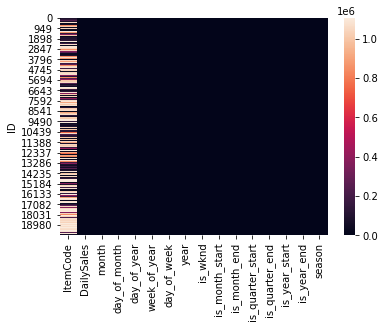

In [ ]:
# cols = ['ItemCode','month','year','day','dayofyear','dayofweek','DailySales','weekofyear']
sns.heatmap(train_df.drop('DateID',axis=1))

In [ ]:
validation_df.shape

(2590, 16)

In [ ]:
train_df.shape

(19921, 17)

In [ ]:
test_df.shape

(2639, 16)

In [ ]:
train_df = train_df.drop('DateID',axis=1)
validation_df = validation_df.drop('DateID',axis=1)
test_df = test_df.drop('DateID',axis=1)

# LIGHTGBM

In [ ]:
# train_df['DateID'] = pd.to_datetime(train_df['DateID'])
# #validation_df['date'] = pd.to_datetime(train_df['date'])

# train_df['month'] = train_df['DateID'].dt.month
# train_df['day'] = train_df['DateID'].dt.dayofweek
# train_df['year'] = train_df['DateID'].dt.year


# # validation_df['month'] = validation_df['date'].dt.month
# # validation_df['day'] = validation_df['date'].dt.dayofweek
# # validation_df['year'] = validation_df['date'].dt.year
# validation_df = validation_df.drop('CategoryCode',axis=1)
col = [i for i in train_df.columns if i not in ['DailySales']]
y = 'DailySales'
train_x, train_y = train_df[col], train_df[y]
val_x = validation_df[col]
test_x = test_df[col]

In [ ]:
train_x.shape, val_x.shape, test_x.shape

((19921, 15), (2590, 15), (2639, 15))

In [ ]:
train_x.head()

,ItemCode,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
ID,,,,,,,,,,,,,,,
0,174436,10,1,274,39,5,2021,1,1,0,1,0,0,0,3
1,118033,10,1,274,39,5,2021,1,1,0,1,0,0,0,3
2,20824,10,1,274,39,5,2021,1,1,0,1,0,0,0,3
3,1061341,10,1,274,39,5,2021,1,1,0,1,0,0,0,3
4,76399,10,1,274,39,5,2021,1,1,0,1,0,0,0,3


In [ ]:
#reshape
# train_x = np.array(train_x).reshape(train_x.shape[0], 1, train_x.shape[1])
# val_x = np.array(val_x).reshape(val_x.shape[0], 1, val_x.shape[1])
# train_x.shape,val_x.shape

((19921, 1, 15), (2590, 1, 15))

In [ ]:
train_x.shape,train_y.shape

((19921, 15), (19921,))

mape

In [ ]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

first model

hyper-parameter tuning

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

In [ ]:
lgbm_params = {

"num_leaves":[20,31,40], # Default 31
"max_depth":[-1,10, 20], # Default -1
"learning_rate":[0.1, 0.05,0.3], # Default 0.1
"n_estimators":[10000,12000, 15000], # Default 100
"min_split_gain":[0.0, 2,5], # Default 0
"min_child_samples":[10, 20, 30], # Default 20
"colsample_bytree":[0.5, 0.8, 1.0], # Default 1
"reg_alpha":[0.0, 0.5, 1], # Default 0
"reg_lambda":[0.0, 0.5, 1], # Default 0
"min_data_in_leaf":[200,1000],
"min_gain_to_split": [3,9]
}

In [ ]:
first_model = lgb.LGBMRegressor(random_state=384)
first_model.fit(train_x, train_y)
print("TRAIN MAPE:", mape(train_y, first_model.predict(train_x)))

TRAIN MAPE: 110.0251287866572


In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

rsearch = RandomizedSearchCV(first_model, lgbm_params, random_state=384, cv=tscv, scoring=make_scorer(mape), verbose = True, n_jobs = -1).fit( train_x, train_y )

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=5 will be ignored. Current value: min_gain_to_split=3


In [ ]:
print(rsearch.best_params_)

{'reg_lambda': 0.0, 'reg_alpha': 0.0, 'num_leaves': 31, 'n_estimators': 10000, 'min_split_gain': 5, 'min_gain_to_split': 3, 'min_data_in_leaf': 1000, 'min_child_samples': 30, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


In [ ]:
model_tuned = lgb.LGBMRegressor(**rsearch.best_params_, random_state=384).fit(train_x, train_y)
print("TRAIN MAPE:", mape(train_y, model_tuned.predict(train_x)))

TRAIN MAPE: 68.59835652653467


In [ ]:
model_tuned_2 = lgb.LGBMRegressor(**rsearch.best_params_, random_state=384).fit(train_x, train_y)
print("TRAIN MAPE:", mape(train_y, model_tuned_2.predict(train_x)))

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=5 will be ignored. Current value: min_gain_to_split=3
TRAIN MAPE: 118.38612761230212


In [ ]:
first_model.fit(train_x, train_y)
print("TRAIN MAPE:", mape(train_y, first_model.predict(train_x)))

TRAIN MAPE: 110.0251287866572


xgboost

In [ ]:
import xgboost as xgb

In [ ]:
matrix_train = xgb.DMatrix(train_x, label = train_y)

In [ ]:
model_1 = xgb.train(params={'objective':'reg:linear','eval_metric':'mape'}
                ,dtrain = matrix_train, num_boost_round = 500)

[09:00:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# %%time

# def model(train_x,train_y,val_x):
#     params = {
#         'nthread': 10,
#          'max_depth': 5,
# #         'max_depth': 9,
#         'task': 'train',
#         'boosting_type': 'gbdt',
#         'objective': 'regression_l1',
#         'metric': 'mape', # this is abs(a-e)/max(1,a)
# #         'num_leaves': 39,
#         'num_leaves': 64,
#         'learning_rate': 0.2,
#        'feature_fraction': 0.9,
# #         'feature_fraction': 0.8108472661400657,
# #         'bagging_fraction': 0.9837558288375402,
#        'bagging_fraction': 0.8,
#         'bagging_freq': 5,
#         'lambda_l1': 3.097758978478437,
#         'lambda_l2': 2.9482537987198496,
# #       'lambda_l1': 0.06,
# #       'lambda_l2': 0.1,
#         'verbose': 1,
#         'min_child_weight': 6.996211413900573,
#         'min_split_gain': 0.037310344962162616,
#         }
    
#     lgb_train = lgb.Dataset(train_x,train_y)
#     # lgb_valid = lgb.Dataset(test_x,test_y)
#     model = lgb.train(params, lgb_train, 3000, verbose_eval=50)
#     y_test = model.predict(val_x,num_iteration=model.best_iteration)
#     return y_test,model

Wall time: 0 ns


Validation Predictions

In [ ]:
val_pred = first_model.predict(val_x)
val_pred

array([8.24985674, 4.48419585, 7.13965396, ..., 8.85966305, 3.97740115,
       7.68231719])

In [ ]:
val_pred_tuned = model_tuned.predict(val_x)
val_pred_tuned

array([ 7.10854693,  1.22323165, 11.03653003, ...,  0.66974024,
       11.15039   ,  6.41168291])

In [ ]:
val_pred_tuned = model_tuned_2.predict(val_x)
val_pred_tuned

array([ 4.34560937,  3.54670555, 10.50773822, ...,  8.34535883,
        6.56495886, 18.86837995])

In [ ]:
val_pred_xgb = model.predict(xgb.DMatrix(val_x))           #xgb0
val_pred_xgb

array([2.7438862 , 0.48539045, 7.0787263 , ..., 2.3554006 , 5.9824047 ,
       4.4974866 ], dtype=float32)

In [ ]:
val_pred_xgb = model_1.predict(xgb.DMatrix(val_x))           #xgb1
val_pred_xgb

array([2.7438862 , 0.48539045, 7.0787263 , ..., 2.3554006 , 5.9824047 ,
       4.4974866 ], dtype=float32)

In [ ]:
validation_df_original['predictions'] = val_pred   #first_model
validation_df_original.head()

,CategoryCode,ItemCode,Week,DateID,predictions
ID,,,,,
0,category_2,1044502,w1,2022-02-14,8.249857
1,category_2,172582,w1,2022-02-14,4.484196
2,category_3,1066570,w1,2022-02-14,7.139654
3,category_2,1090240,w1,2022-02-14,3.591668
4,category_3,1097143,w1,2022-02-14,10.128552


In [ ]:
validation_df_original['predictions'] = val_pred_tuned       #model_tuned
validation_df_original.head()

,CategoryCode,ItemCode,Week,DateID,predictions
ID,,,,,
0,category_2,1044502,w1,2022-02-14,4.345609
1,category_2,172582,w1,2022-02-14,3.546706
2,category_3,1066570,w1,2022-02-14,10.507738
3,category_2,1090240,w1,2022-02-14,6.746429
4,category_3,1097143,w1,2022-02-14,4.037358


In [ ]:
validation_df_original['predictions'] = val_pred_xgb  #xgb_model
validation_df_original.head()

,CategoryCode,ItemCode,Week,DateID,predictions
ID,,,,,
0,category_2,1044502,w1,2022-02-14,2.743886
1,category_2,172582,w1,2022-02-14,0.485390
2,category_3,1066570,w1,2022-02-14,7.078726
3,category_2,1090240,w1,2022-02-14,2.789671
4,category_3,1097143,w1,2022-02-14,9.287245


In [ ]:
validation_df_original['predictions'] = val_pred_xgb  #xgb_model
validation_df_original.head()

,CategoryCode,ItemCode,Week,DateID,predictions
ID,,,,,
0,category_2,1044502,w1,2022-02-14,2.743886
1,category_2,172582,w1,2022-02-14,0.485390
2,category_3,1066570,w1,2022-02-14,7.078726
3,category_2,1090240,w1,2022-02-14,2.789671
4,category_3,1097143,w1,2022-02-14,9.287245


# validation set

In [ ]:
validation_data = pd.read_csv('validation_data.csv')
validation_data

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,11
1,category_2,1105009,w1,11
2,category_2,913561,w4,5
3,category_1,1048975,w4,30
4,category_1,17287,w2,60
...,...,...,...,...
365,category_2,124954,w2,43
366,category_2,40759,w1,48
367,category_1,1090303,w1,19
368,category_2,1090276,w3,6


In [ ]:
weekly_data = pd.DataFrame(columns=['CategoryCode','ItemCode','Week','WeeklySales'])
for index,row in validation_data.iterrows():
    a=row['CategoryCode']
    b=row['ItemCode']
    c=row['Week']
    d=(validation_df_original.loc[(validation_df_original.CategoryCode==a)&(validation_df_original.ItemCode==b)&(validation_df_original.Week==c)]).predictions.sum().round()
    weekly_data = weekly_data.append({'CategoryCode':a,'ItemCode':b,'Week':c,'WeeklySales':d},ignore_index=True,sort=False)
    

In [ ]:
weekly_data   #first_model

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,37.0
1,category_2,1105009,w1,31.0
2,category_2,913561,w4,27.0
3,category_1,1048975,w4,47.0
4,category_1,17287,w2,120.0
...,...,...,...,...
365,category_2,124954,w2,30.0
366,category_2,40759,w1,65.0
367,category_1,1090303,w1,25.0
368,category_2,1090276,w3,23.0


In [ ]:
weekly_data   #model_tuned

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,37.0
1,category_2,1105009,w1,31.0
2,category_2,913561,w4,27.0
3,category_1,1048975,w4,47.0
4,category_1,17287,w2,120.0
...,...,...,...,...
365,category_2,124954,w2,30.0
366,category_2,40759,w1,65.0
367,category_1,1090303,w1,25.0
368,category_2,1090276,w3,23.0


In [ ]:
weekly_data  #xgboost

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,24.0
1,category_2,1105009,w1,11.0
2,category_2,913561,w4,7.0
3,category_1,1048975,w4,25.0
4,category_1,17287,w2,64.0
...,...,...,...,...
365,category_2,124954,w2,44.0
366,category_2,40759,w1,55.0
367,category_1,1090303,w1,21.0
368,category_2,1090276,w3,15.0


MAPE calculation

In [ ]:
validation_data.head()

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,11
1,category_2,1105009,w1,11
2,category_2,913561,w4,5
3,category_1,1048975,w4,30
4,category_1,17287,w2,60


In [ ]:
weekly_data.head()    #first_model

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,37.0
1,category_2,1105009,w1,31.0
2,category_2,913561,w4,27.0
3,category_1,1048975,w4,47.0
4,category_1,17287,w2,120.0


In [ ]:
weekly_data.head()   #model_tuned

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,37.0
1,category_2,1105009,w1,31.0
2,category_2,913561,w4,27.0
3,category_1,1048975,w4,47.0
4,category_1,17287,w2,120.0


In [ ]:
weekly_data.head()   #xgb_model

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,24.0
1,category_2,1105009,w1,11.0
2,category_2,913561,w4,7.0
3,category_1,1048975,w4,25.0
4,category_1,17287,w2,64.0


In [ ]:
weekly_data.head()

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,24.0
1,category_2,1105009,w1,11.0
2,category_2,913561,w4,7.0
3,category_1,1048975,w4,25.0
4,category_1,17287,w2,64.0


In [ ]:
mape(validation_data['WeeklySales'],weekly_data['WeeklySales'])   #first_model

161.581071042429

In [ ]:
mape(validation_data['WeeklySales'],weekly_data['WeeklySales'])  #model_tuned

187.3439610495313

In [ ]:
mape(validation_data['WeeklySales'],weekly_data['WeeklySales'])    #xgb_model

120.1318358161646

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(validation_data['WeeklySales'],weekly_data['WeeklySales'])

1.6526481942175792